### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
df = pd.read_csv('./assets/skin_cancer_dataset.csv')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (10000, 14)

First few rows:
   Age  Gender Skin_Type Sun_Exposure Family_History  Mole_Count Itchiness  \
0   69    Male    Type V     Moderate             No           6       Yes   
1   32    Male    Type V     Moderate             No           3       Yes   
2   89  Female   Type II          Low            Yes           4       Yes   
3   78    Male   Type II         High            Yes           8       Yes   
4   38  Female  Type III          Low             No           1        No   

  Bleeding Asymmetry Border_Irregularity Color_Variation  Diameter_mm  \
0       No       Yes                  No              No         6.90   
1       No        No                 Yes              No         2.79   
2      Yes       Yes                 Yes             Yes         5.41   
3       No        No                  No              No         2.52   
4      Yes       Yes                  No              No         4.09   

  Evolution  Skin_Cancer  
0        No          

In [4]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  10000 non-null  int64  
 1   Gender               10000 non-null  object 
 2   Skin_Type            10000 non-null  object 
 3   Sun_Exposure         10000 non-null  object 
 4   Family_History       10000 non-null  object 
 5   Mole_Count           10000 non-null  int64  
 6   Itchiness            10000 non-null  object 
 7   Bleeding             10000 non-null  object 
 8   Asymmetry            10000 non-null  object 
 9   Border_Irregularity  10000 non-null  object 
 10  Color_Variation      10000 non-null  object 
 11  Diameter_mm          10000 non-null  float64
 12  Evolution            10000 non-null  object 
 13  Skin_Cancer          10000 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 1.1+ MB
None


In [5]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Age                    0
Gender                 0
Skin_Type              0
Sun_Exposure           0
Family_History         0
Mole_Count             0
Itchiness              0
Bleeding               0
Asymmetry              0
Border_Irregularity    0
Color_Variation        0
Diameter_mm            0
Evolution              0
Skin_Cancer            0
dtype: int64


In [6]:
print("\nTarget Variable Distribution:")
print(df['Skin_Cancer'].value_counts())


Target Variable Distribution:
Skin_Cancer
1    5860
0    4140
Name: count, dtype: int64


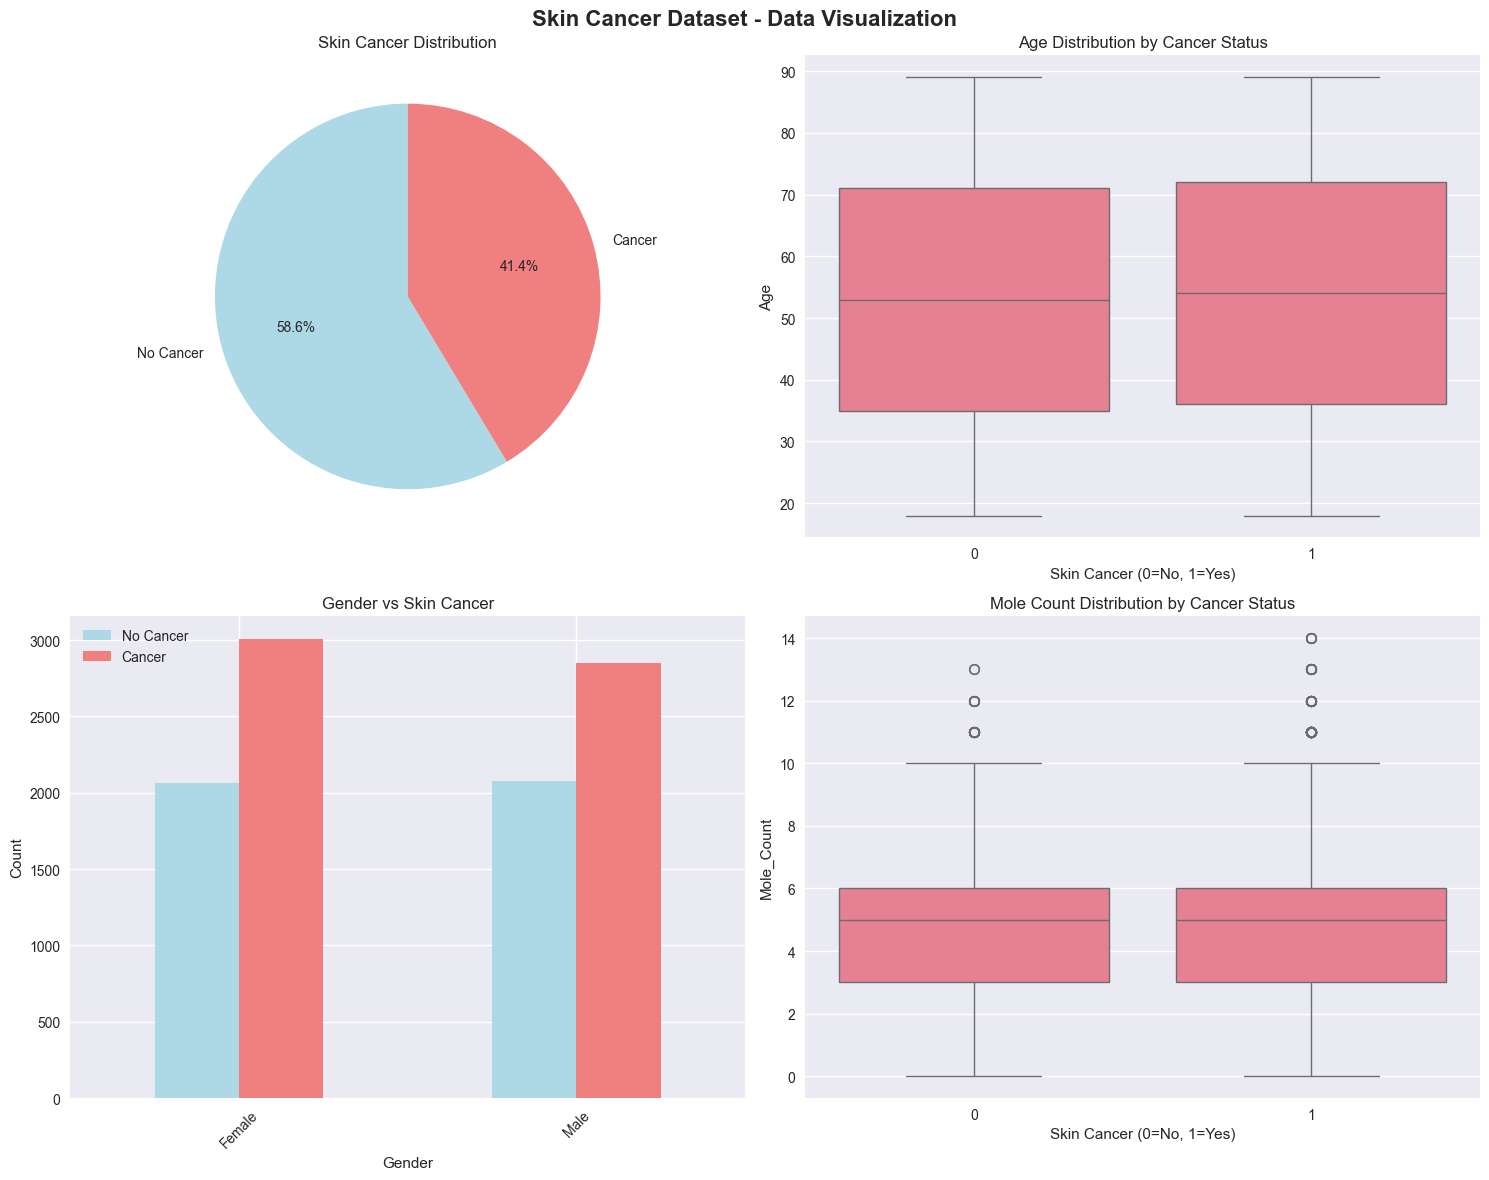

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Skin Cancer Dataset - Data Visualization', fontsize=16, fontweight='bold')

# 1. Target variable distribution
axes[0, 0].pie(df['Skin_Cancer'].value_counts(), labels=['No Cancer', 'Cancer'], 
               autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[0, 0].set_title('Skin Cancer Distribution')

# 2. Age distribution by cancer status
sns.boxplot(data=df, x='Skin_Cancer', y='Age', ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Cancer Status')
axes[0, 1].set_xlabel('Skin Cancer (0=No, 1=Yes)')

# 3. Gender distribution
gender_cancer = pd.crosstab(df['Gender'], df['Skin_Cancer'])
gender_cancer.plot(kind='bar', ax=axes[1, 0], color=['lightblue', 'lightcoral'])
axes[1, 0].set_title('Gender vs Skin Cancer')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(['No Cancer', 'Cancer'])
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Mole count distribution
sns.boxplot(data=df, x='Skin_Cancer', y='Mole_Count', ax=axes[1, 1])
axes[1, 1].set_title('Mole Count Distribution by Cancer Status')
axes[1, 1].set_xlabel('Skin Cancer (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

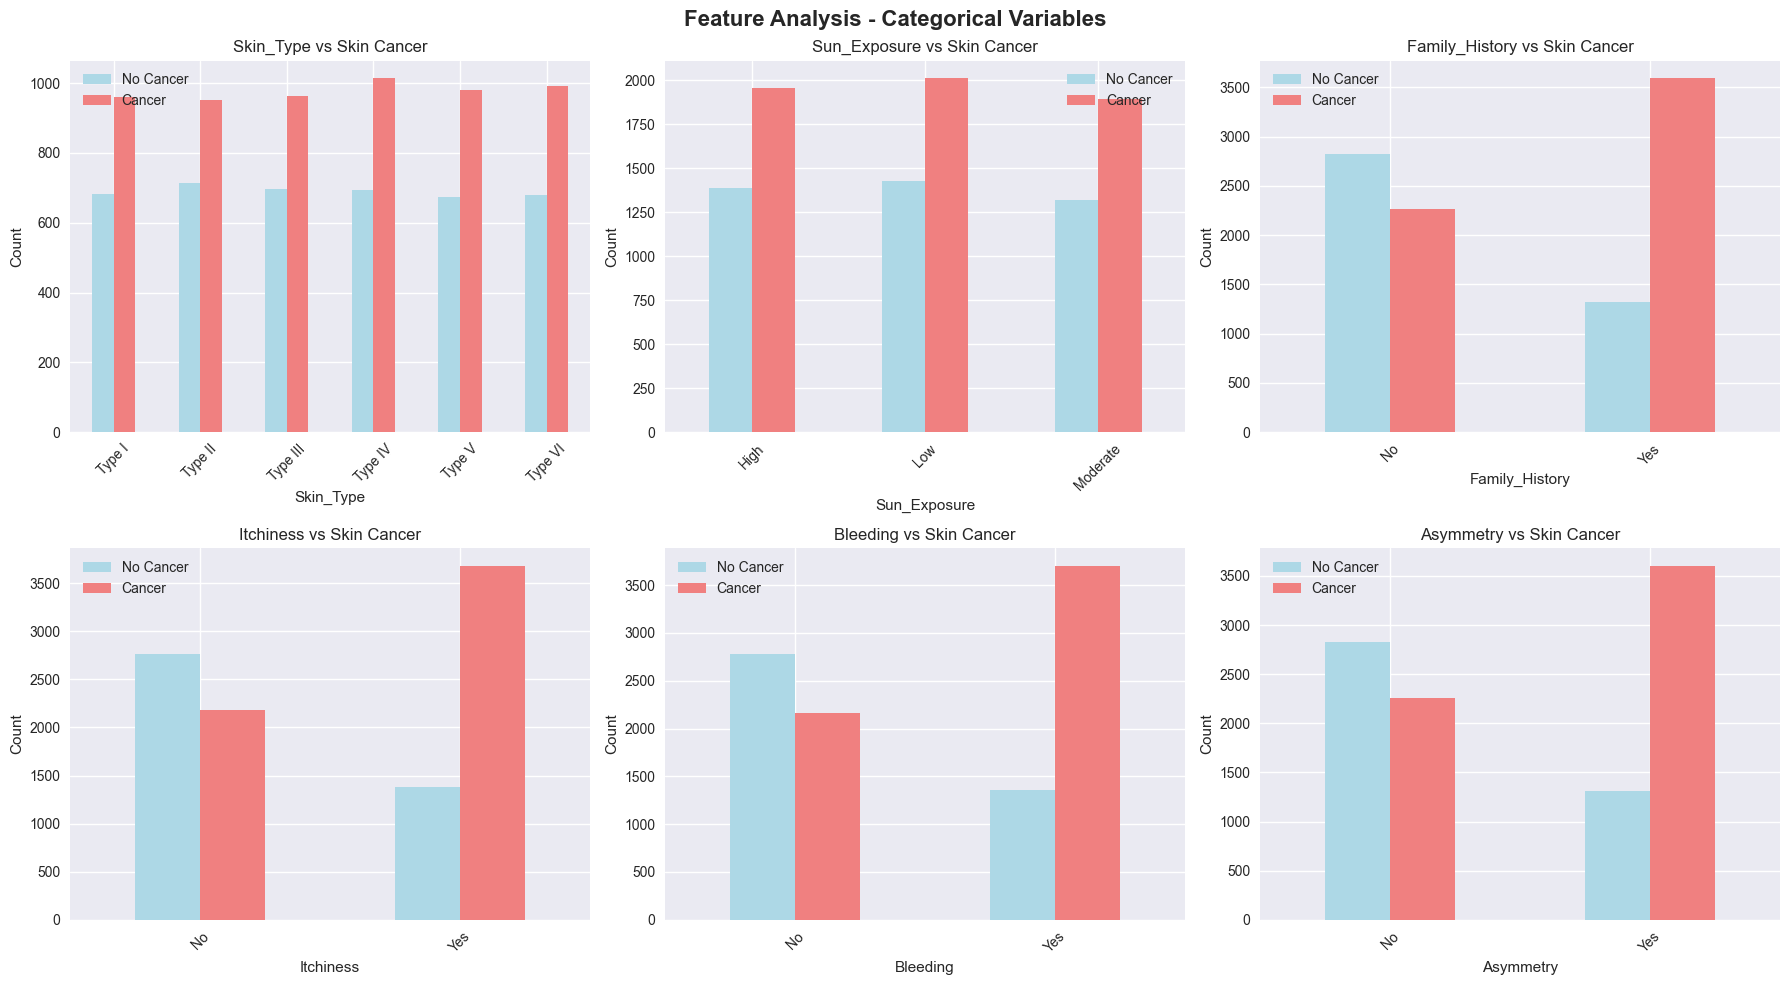

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Analysis - Categorical Variables', fontsize=16, fontweight='bold')

# Categorical features analysis
categorical_features = ['Skin_Type', 'Sun_Exposure', 'Family_History', 'Itchiness', 
                       'Bleeding', 'Asymmetry', 'Border_Irregularity', 'Color_Variation', 'Evolution']

for i, feature in enumerate(categorical_features[:6]):
    row = i // 3
    col = i % 3
    feature_cancer = pd.crosstab(df[feature], df['Skin_Cancer'])
    feature_cancer.plot(kind='bar', ax=axes[row, col], color=['lightblue', 'lightcoral'])
    axes[row, col].set_title(f'{feature} vs Skin Cancer')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Count')
    axes[row, col].legend(['No Cancer', 'Cancer'])
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

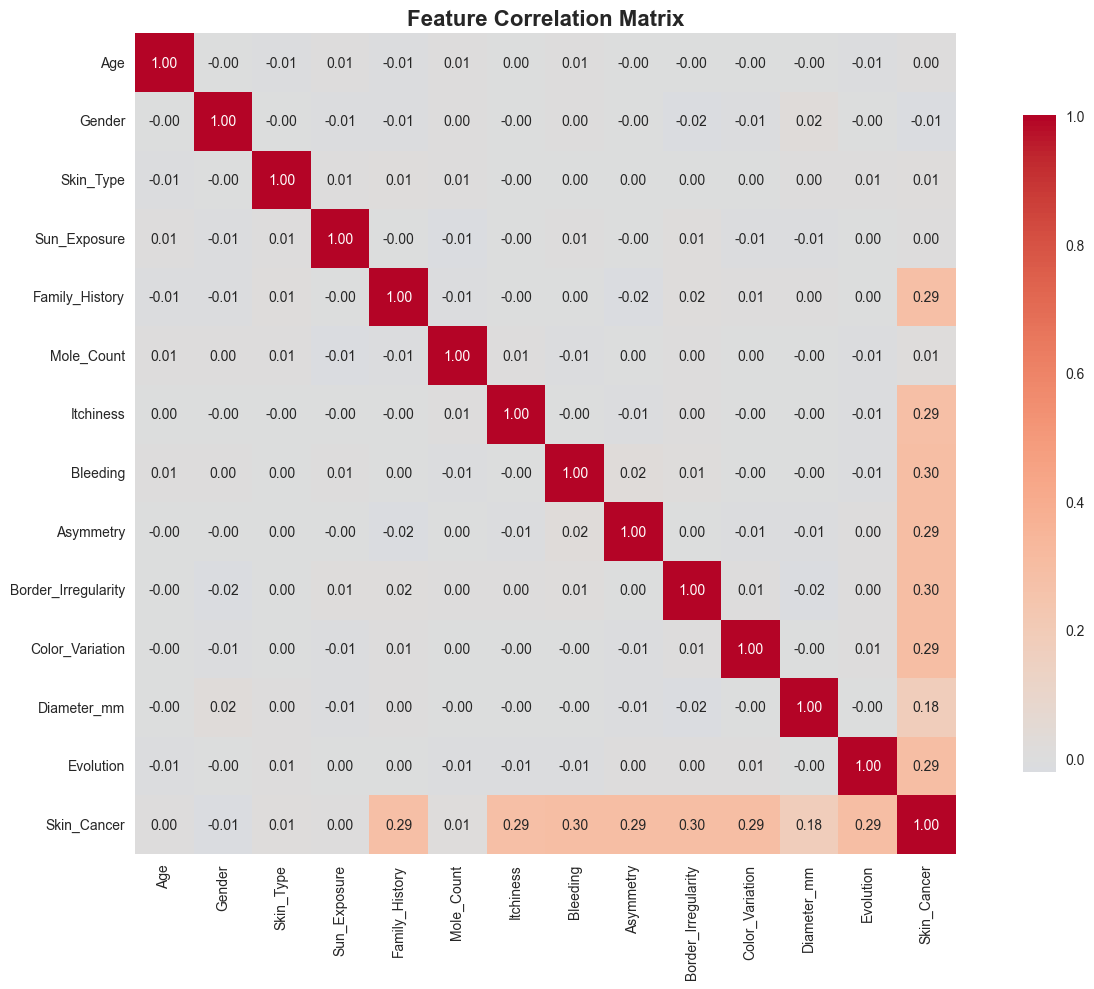

In [11]:
# Set figure size
plt.figure(figsize=(14, 10))

# Create a copy for correlation analysis
df_corr = df.copy()

# Encode categorical variables
le = LabelEncoder()
for column in df_corr.select_dtypes(include=['object']).columns:
    df_corr[column] = le.fit_transform(df_corr[column])

# Compute correlation matrix
correlation_matrix = df_corr.corr()

# Plot heatmap (no mask)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})

# Add title and layout adjustments
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### FEATURE ANALYSIS

In [ ]:
X = df.drop('Skin_Cancer', axis=1)
y = df['Skin_Cancer']

# Encode categorical variables
X_encoded = X.copy()
label_encoders = {}

for column in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[column] = le.fit_transform(X_encoded[column])
    label_encoders[column] = le

# Feature importance using Random Forest
rf_feature = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature.fit(X_encoded, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_feature.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

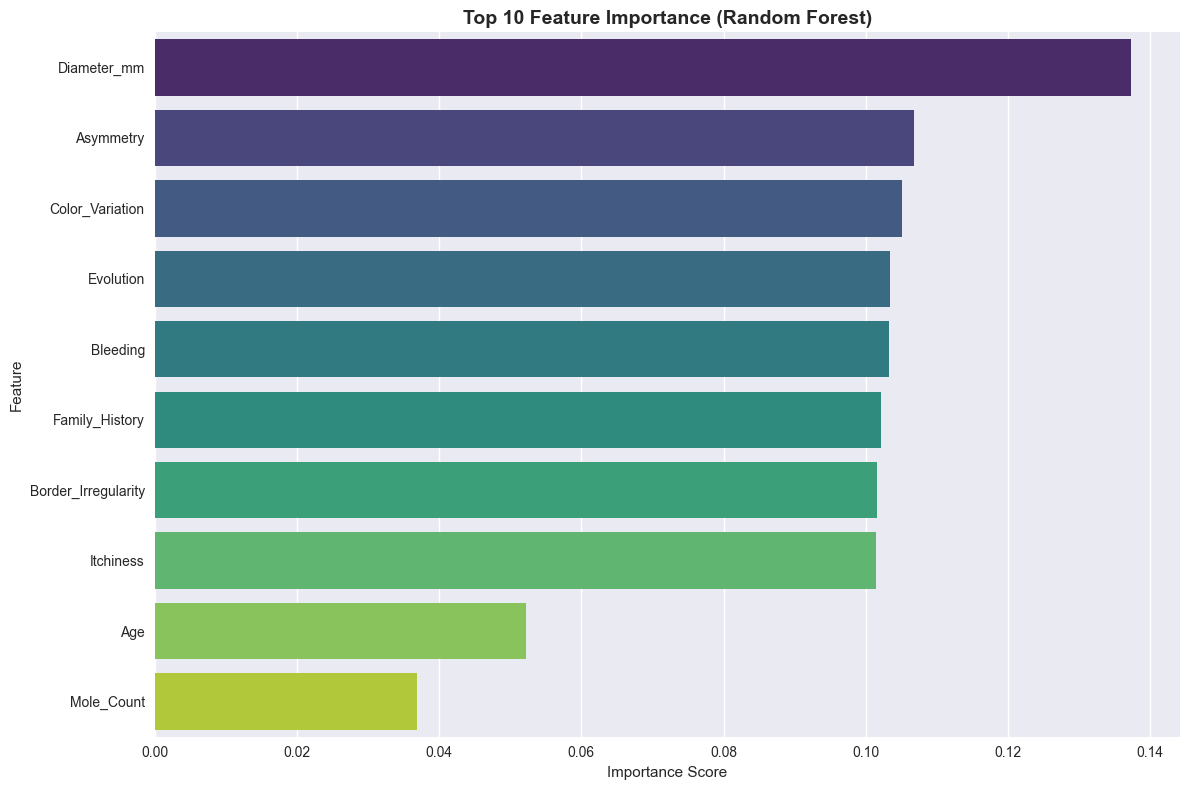

In [14]:
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [15]:
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)


DATA PREPROCESSING


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, 
                                                    random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")


Training set shape: (7000, 13)
Test set shape: (3000, 13)


### MODEL BUILDING AND COMPARISON

In [26]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

# Store results
results = {}
model_performance = []

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Fit the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    model_performance.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV Mean': cv_mean,
        'CV Std': cv_std
    })
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"CV Score: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")


Training Logistic Regression...
Accuracy: 0.9900
Precision: 0.9937
Recall: 0.9892
F1-Score: 0.9914
ROC-AUC: 0.9981
CV Score: 0.9887 (+/- 0.0051)

Training Random Forest...
Accuracy: 0.9927
Precision: 0.9926
Recall: 0.9949
F1-Score: 0.9938
ROC-AUC: 0.9997
CV Score: 0.9939 (+/- 0.0052)

Training SVM...
Accuracy: 0.9773
Precision: 0.9851
Recall: 0.9761
F1-Score: 0.9806
ROC-AUC: 0.9983
CV Score: 0.9753 (+/- 0.0098)

Training Gradient Boosting...
Accuracy: 0.9987
Precision: 1.0000
Recall: 0.9977
F1-Score: 0.9989
ROC-AUC: 1.0000
CV Score: 0.9981 (+/- 0.0011)

Training K-Nearest Neighbors...
Accuracy: 0.9470
Precision: 0.9662
Recall: 0.9425
F1-Score: 0.9542
ROC-AUC: 0.9871
CV Score: 0.9231 (+/- 0.0134)

Training Decision Tree...
Accuracy: 0.9943
Precision: 0.9943
Recall: 0.9960
F1-Score: 0.9952
ROC-AUC: 0.9940
CV Score: 0.9926 (+/- 0.0055)

Training Naive Bayes...
Accuracy: 0.9733
Precision: 0.9600
Recall: 0.9960
F1-Score: 0.9777
ROC-AUC: 0.9986
CV Score: 0.9749 (+/- 0.0093)


In [30]:
performance_df = pd.DataFrame(model_performance)
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print(performance_df.round(4))


MODEL PERFORMANCE COMPARISON
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0  Logistic Regression    0.9900     0.9937  0.9892    0.9914   0.9981   
1        Random Forest    0.9927     0.9926  0.9949    0.9938   0.9997   
2                  SVM    0.9773     0.9851  0.9761    0.9806   0.9983   
3    Gradient Boosting    0.9987     1.0000  0.9977    0.9989   1.0000   
4  K-Nearest Neighbors    0.9470     0.9662  0.9425    0.9542   0.9871   
5        Decision Tree    0.9943     0.9943  0.9960    0.9952   0.9940   
6          Naive Bayes    0.9733     0.9600  0.9960    0.9777   0.9986   

   CV Mean  CV Std  
0   0.9887  0.0026  
1   0.9939  0.0026  
2   0.9753  0.0049  
3   0.9981  0.0006  
4   0.9231  0.0067  
5   0.9926  0.0028  
6   0.9749  0.0047  



HYPERPARAMETER TUNING


In [31]:
print("\n" + "="*50)
print("FINAL MODEL EVALUATION")
print("="*50)


FINAL MODEL EVALUATION


Best performing model: Gradient Boosting

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1242
           1       1.00      1.00      1.00      1758

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



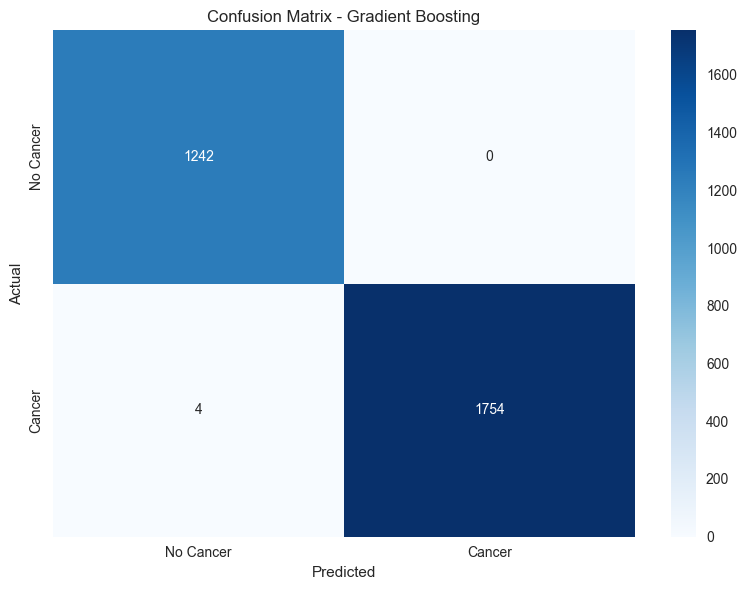

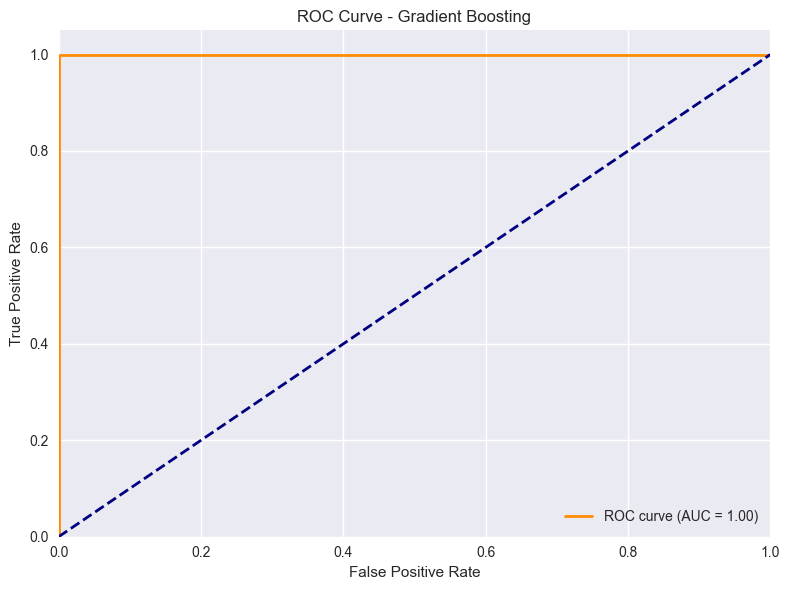

In [32]:
# Find the best model based on F1-Score
best_model_name = performance_df.loc[performance_df['F1-Score'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"Best performing model: {best_model_name}")

# Final predictions
final_predictions = best_model.predict(X_test_scaled)
final_predictions_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, final_predictions))

# Confusion matrix
cm = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_predictions_proba)
roc_auc = roc_auc_score(y_test, final_predictions_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# =============================================================================
# 7. SAVE THE MODEL AND PREPROCESSING OBJECTS
# =============================================================================

In [ ]:
import joblib

# Save the best model and preprocessing objects
joblib.dump(best_model, 'skin_cancer_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("\nModel and preprocessing objects saved successfully!")
print("Files created:")
print("- skin_cancer_model.pkl")
print("- scaler.pkl") 
print("- label_encoders.pkl")

# Print final model details
print(f"\nFinal Model: {best_model_name}")
print(f"Final Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Final Test F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"Final Test ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")